In [17]:
import os
import sys
from chordUtils import json2lab
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp
from sklearn.model_selection import KFold


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [18]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [19]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = KFold(n_splits = nfolds, shuffle = True, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(chromas):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(kinds, chromas, ncomp, nfolds=5)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

# No normalization

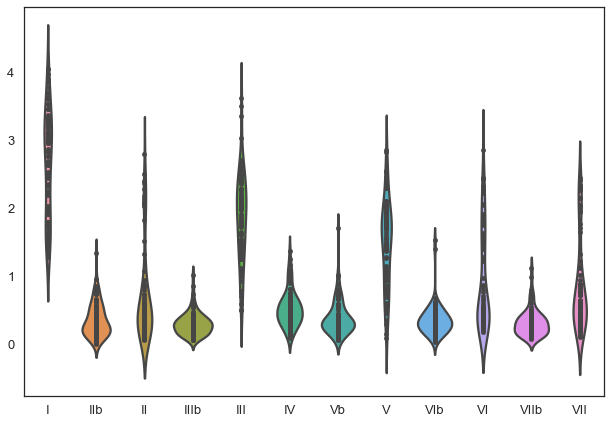

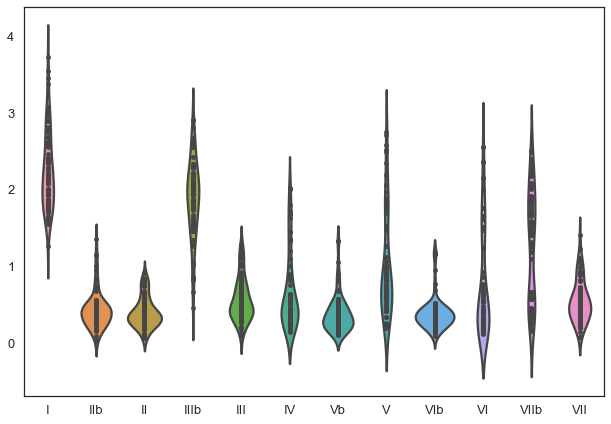

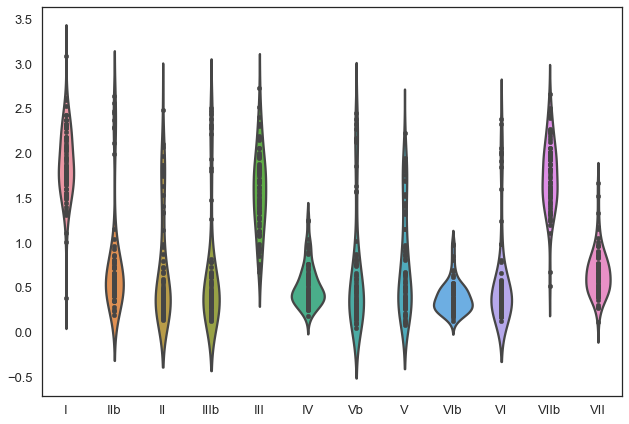

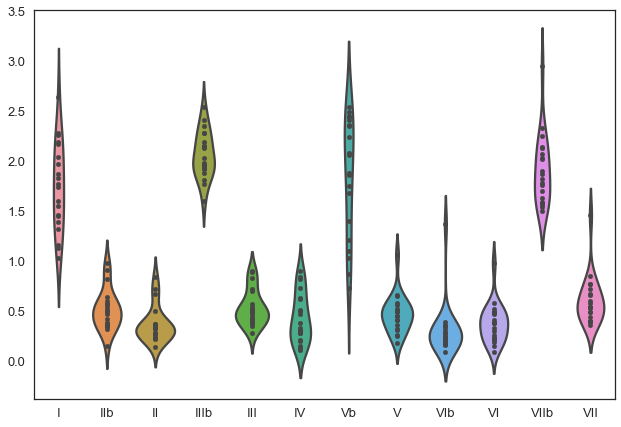

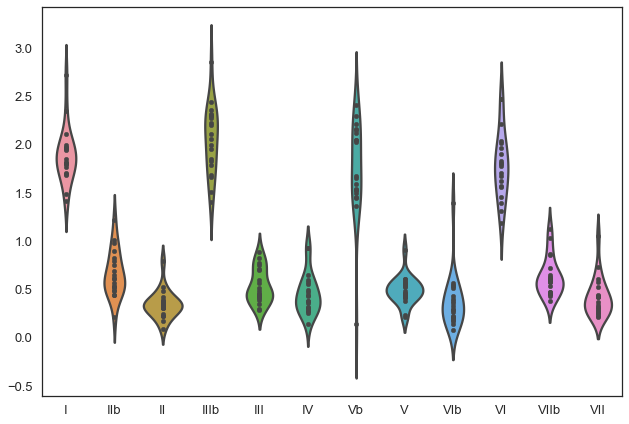

maj 98.8505747126 %
min 96.4705882353 %
dom 98.7012987013 %
hdim7 100.0 %
dim 100.0 %
total:  98.2698961938 %
maj 100.0 %
min 100.0 %
dom 100.0 %
hdim7 100.0 %
dim 100.0 %
total:  100.0 %
maj BIC:  182.214933579  N:  13
min BIC:  -529.77305656  N:  8
dom BIC:  435.441650223  N:  14
hdim7 BIC:  -627.79116174  N:  3
dim BIC:  -537.144092495  N:  3


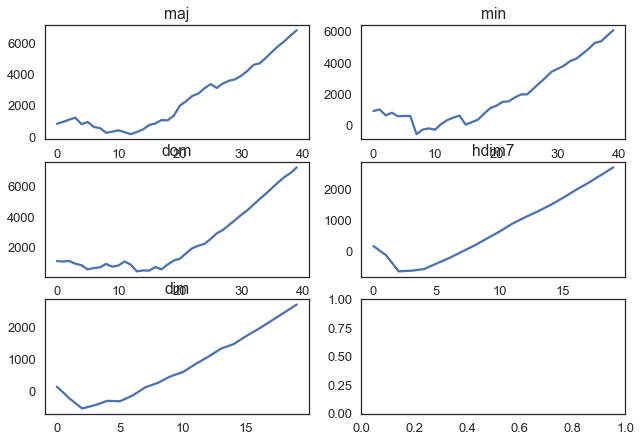

[ 13.   8.  14.   3.   3.]
[  98.35609793  100.          100.           99.91341991  100.        ]
[ 89.61282517  80.61705989  74.36781609  72.64367816  67.11433757]


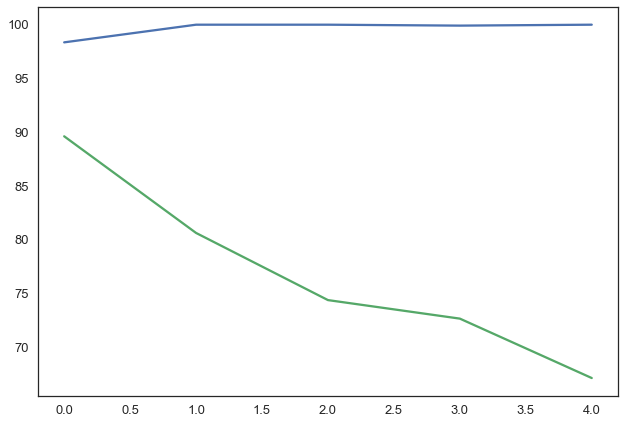

In [41]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
model = fitConstModel(kinds, chromas, [3,2,2,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas)
print n_components

trains, tests = trainTestSymmetricalModels(kinds, chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()


# Just L1

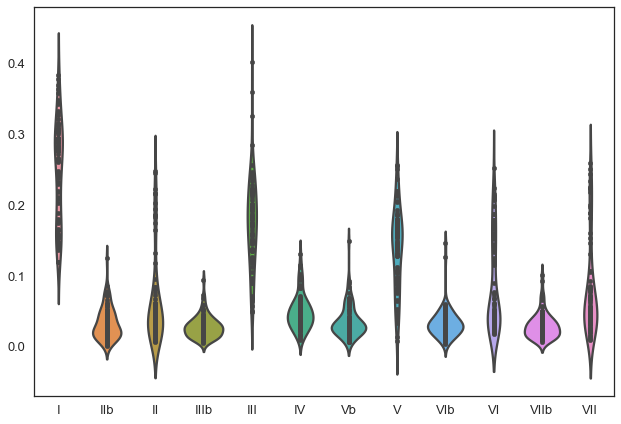

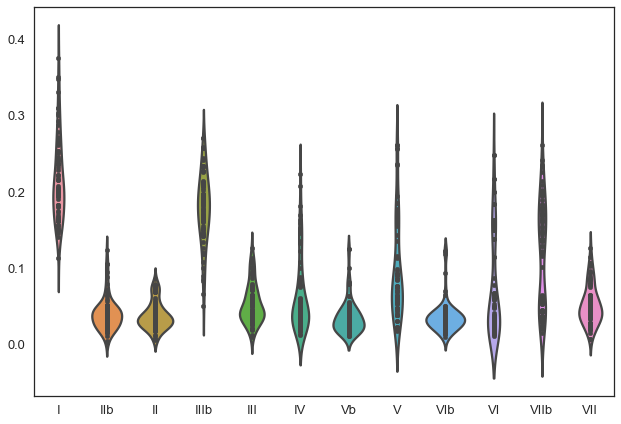

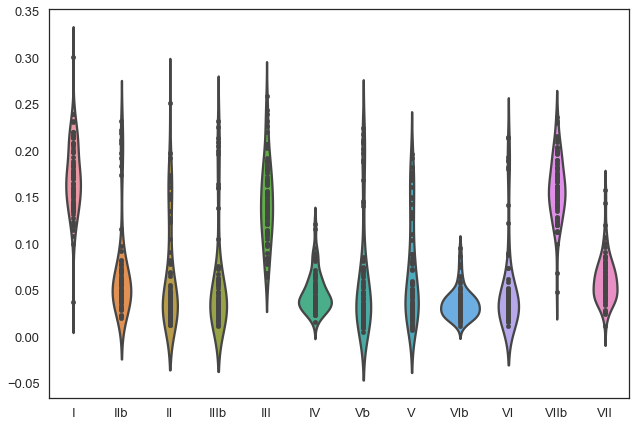

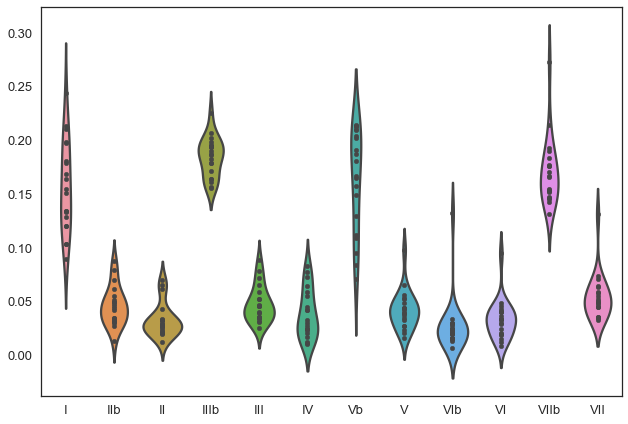

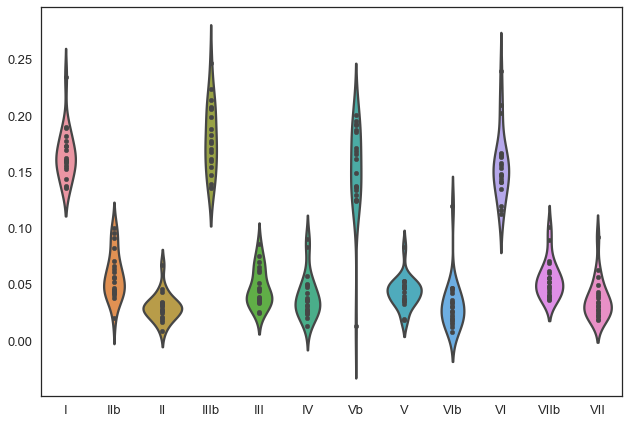

maj BIC:  -4617.75760271  N:  1
min BIC:  -4364.23519554  N:  1
dom BIC:  -3753.34999996  N:  1
hdim7 BIC:  -1169.42207371  N:  3
dim BIC:  -1143.92773901  N:  2


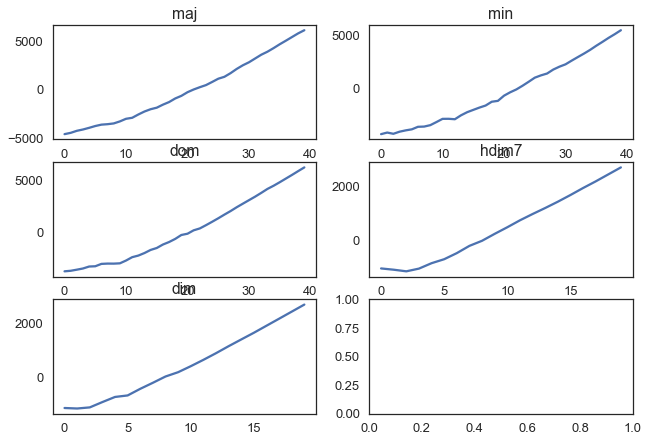

[ 1.  1.  1.  3.  2.]
[  97.75041051   99.39431258  100.          100.          100.        ]
[ 87.17483364  78.54204477  77.84029038  72.30490018  64.34361766]


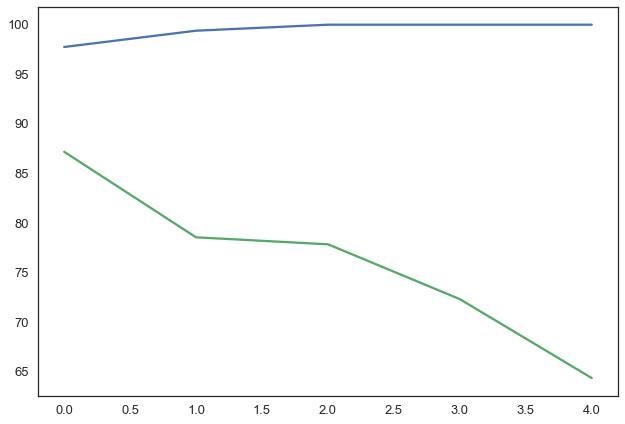

In [45]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l1Chromas = normalize(chromas)
violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [2,7,2,1,1])
score(model, kinds, l1Chromas)
n_components = findOptimalNComponentsByBIC(l1Chromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l1Chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()


# Just L2

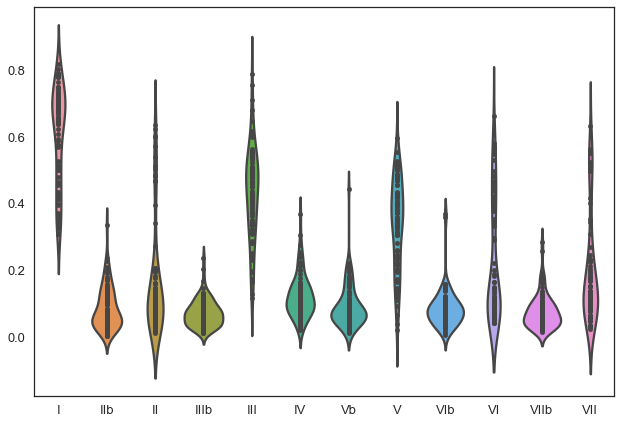

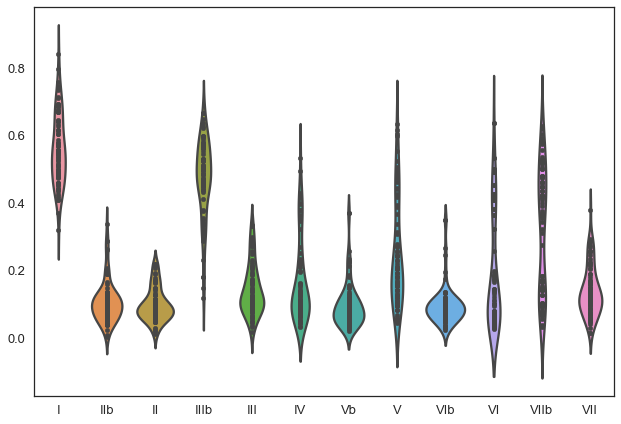

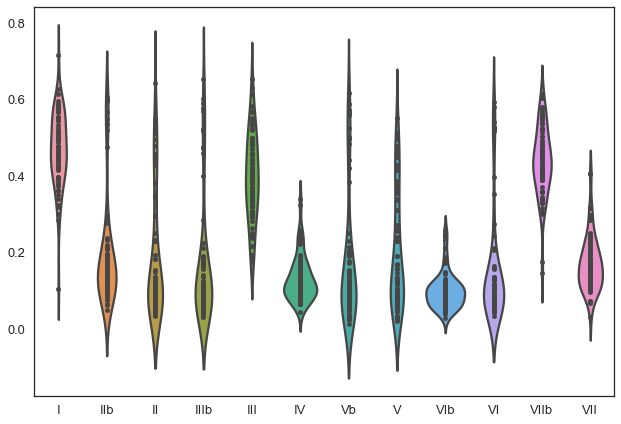

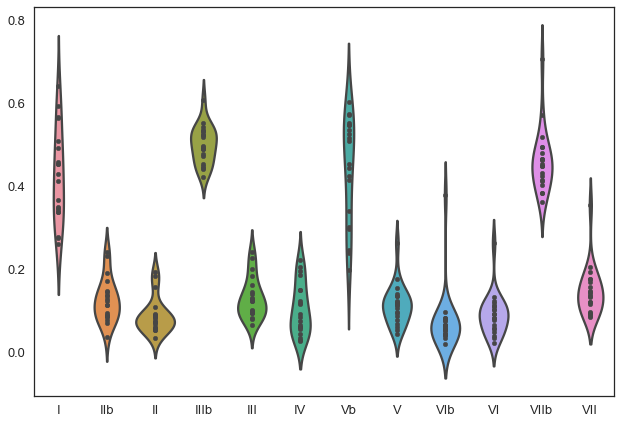

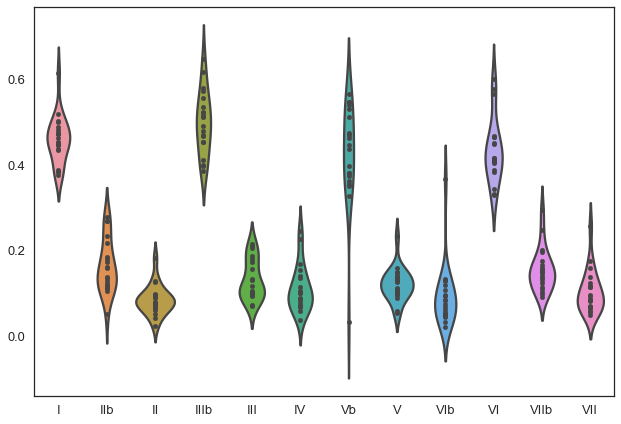

maj BIC:  -2179.33728722  N:  2
min BIC:  -2471.2143573  N:  4
dom BIC:  -1845.01865143  N:  10
hdim7 BIC:  -942.042665896  N:  3
dim BIC:  -874.611340191  N:  3


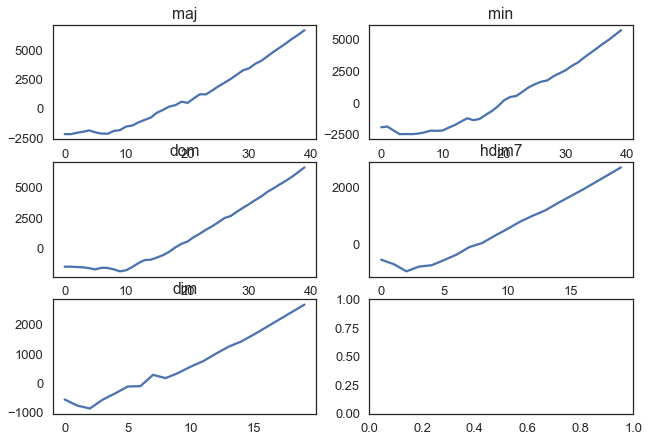

[  2.   4.  10.   3.   3.]
[  98.44230482   99.74025974  100.          100.          100.        ]
[ 87.87053842  77.83424077  76.10405324  69.54022989  66.40653358]


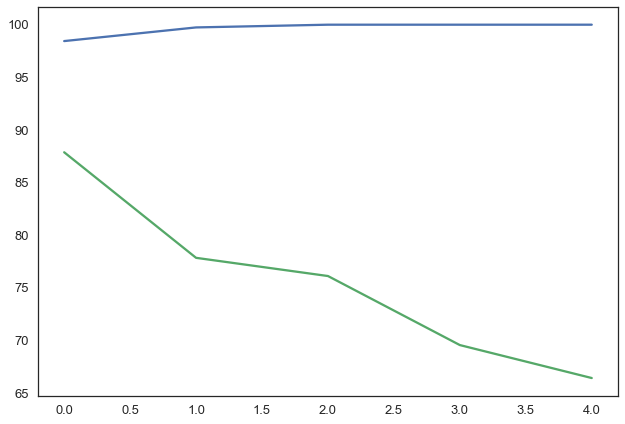

In [46]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l2Chromas = normalize(chromas, norm='l2')
violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
score(model, kinds, l2Chromas)
n_components = findOptimalNComponentsByBIC(l2Chromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l2Chromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Just Max

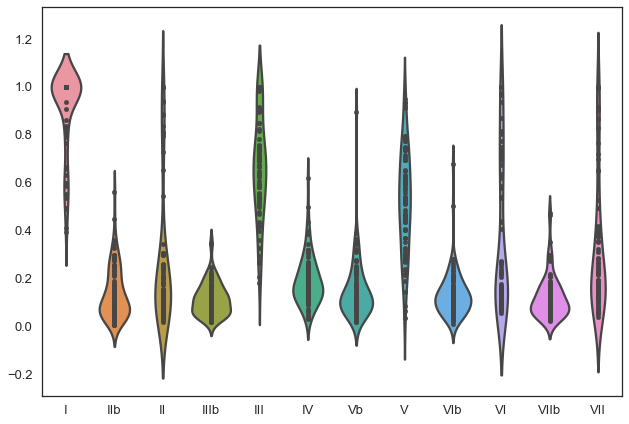

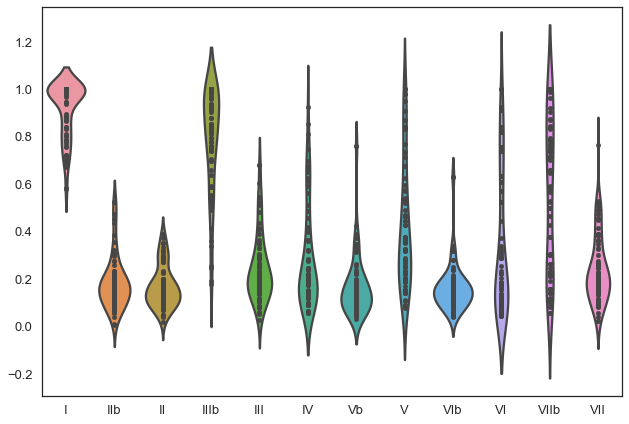

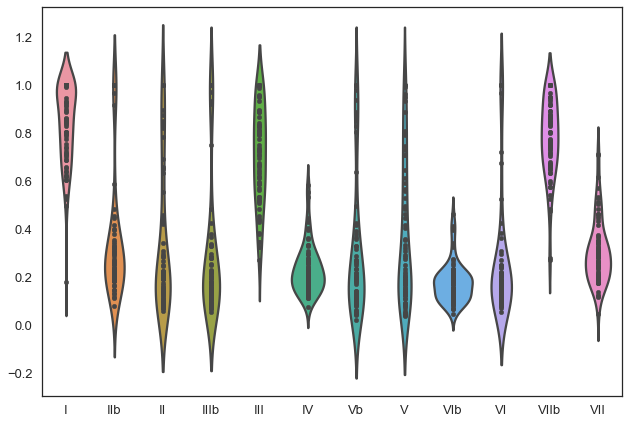

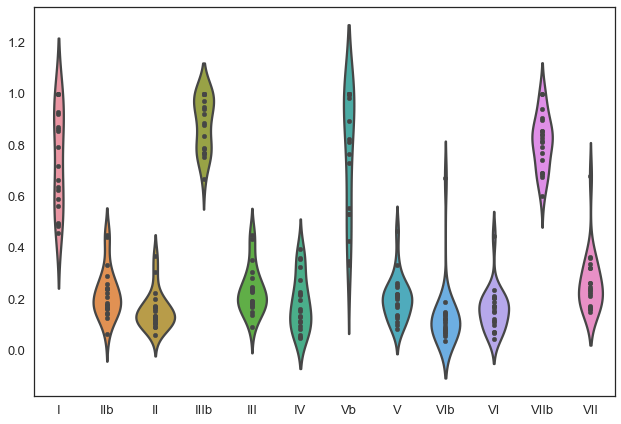

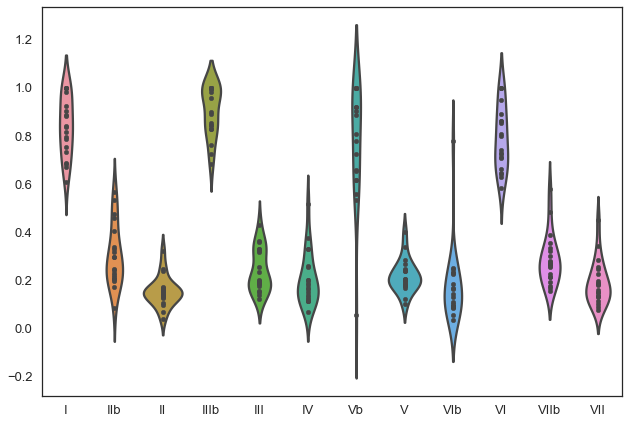

maj BIC:  -1676.33642886  N:  8
min BIC:  -1579.12483122  N:  12
dom BIC:  -1050.25782268  N:  10
hdim7 BIC:  -788.457061558  N:  4
dim BIC:  -705.996576886  N:  3


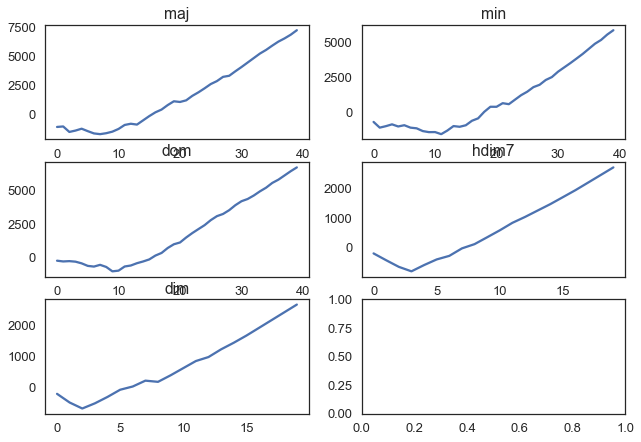

[  8.  12.  10.   4.   3.]
[  97.75003732   99.65367965   99.82721302  100.          100.        ]
[ 86.14035088  79.56442831  75.40834846  66.07985481  59.14700544]


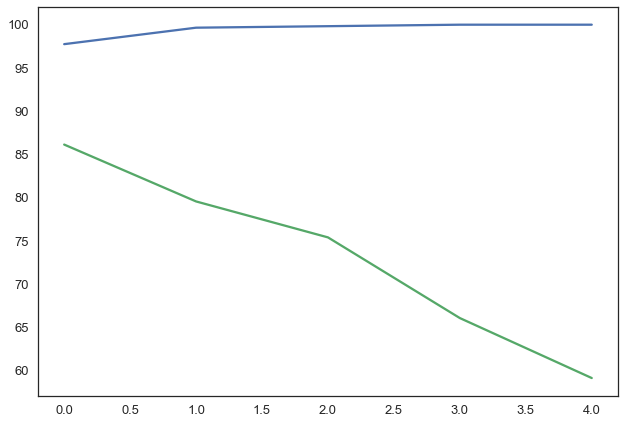

In [47]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

maxChromas = normalize(chromas, norm='max')
violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
score(model, kinds, maxChromas)
n_components = findOptimalNComponentsByBIC(maxChromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, maxChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Log L1

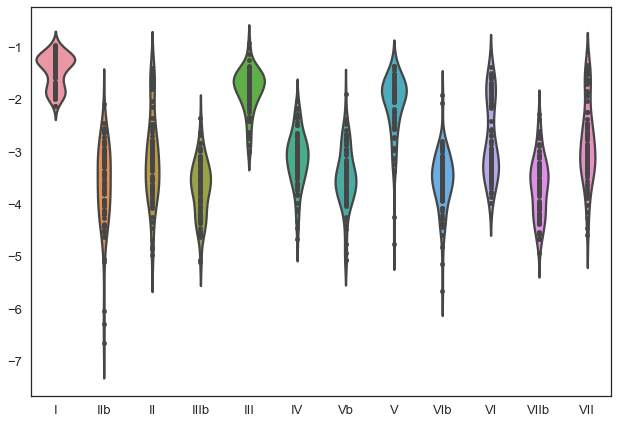

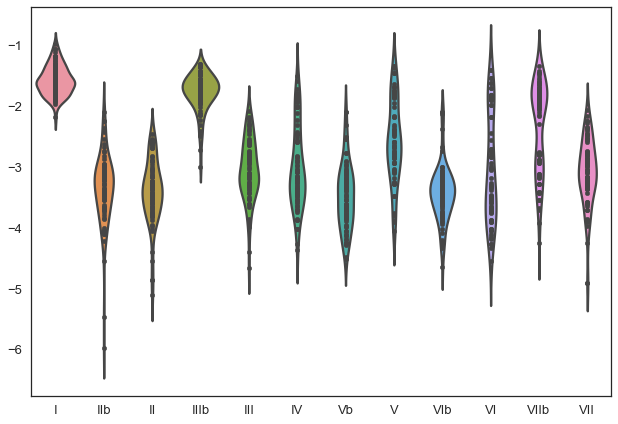

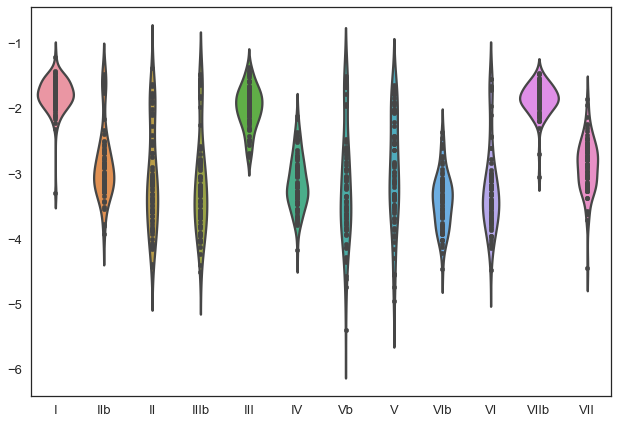

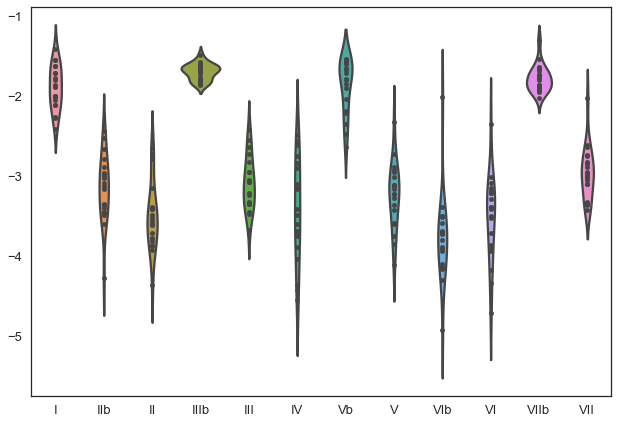

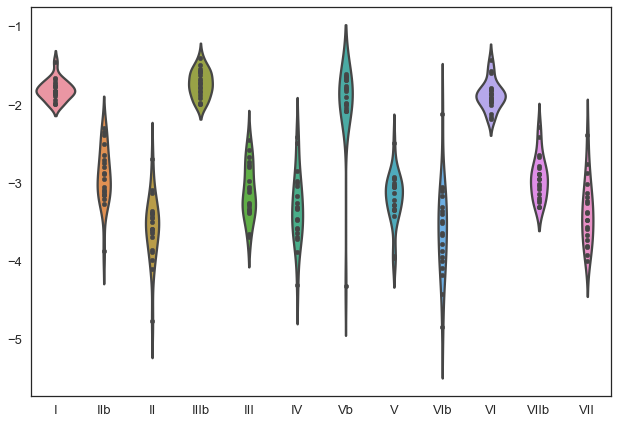

maj BIC:  885.867551129  N:  14
min BIC:  207.057178541  N:  9
dom BIC:  -167.971516688  N:  14
hdim7 BIC:  -509.379490491  N:  3
dim BIC:  -260.139407  N:  5


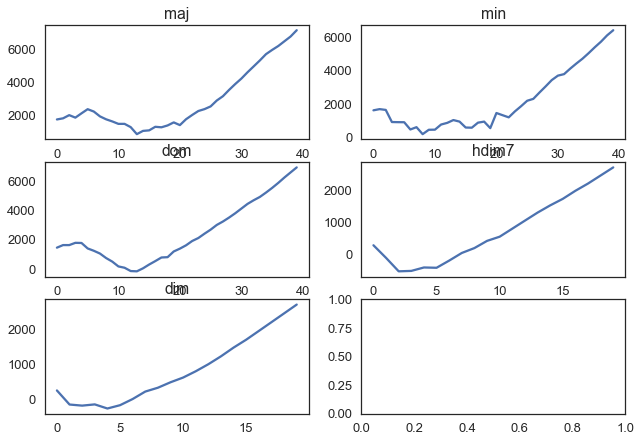

[ 14.   9.  14.   3.   5.]
[  97.49029706   99.56709957   99.91341991  100.          100.        ]
[ 86.83605566  80.95583787  79.91530551  76.45493043  68.44525106]


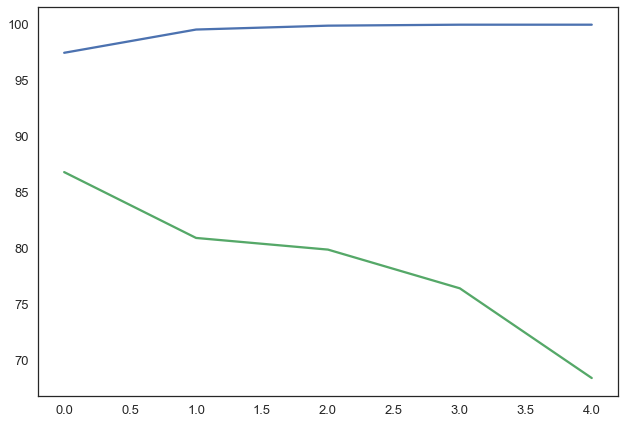

In [51]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

l1logChromas = logNormalize(chromas)
violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,3,3,1,1])
score(model, kinds, l1logChromas)
n_components = findOptimalNComponentsByBIC(l1logChromas)
print n_components
trains, tests = trainTestSymmetricalModels(kinds, l1logChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()

# Compositional data model

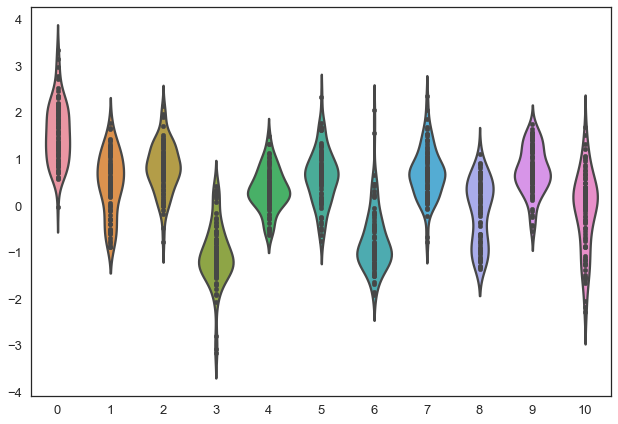

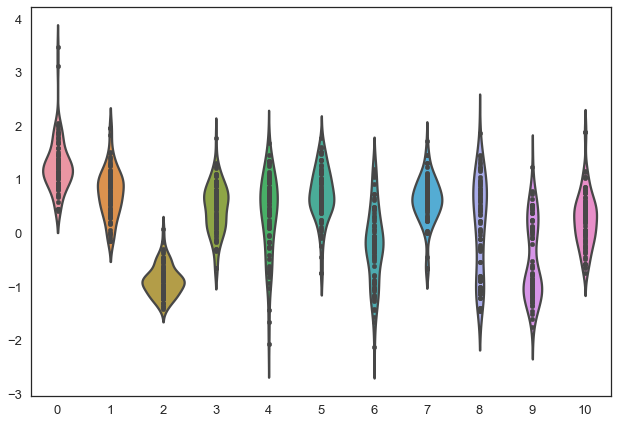

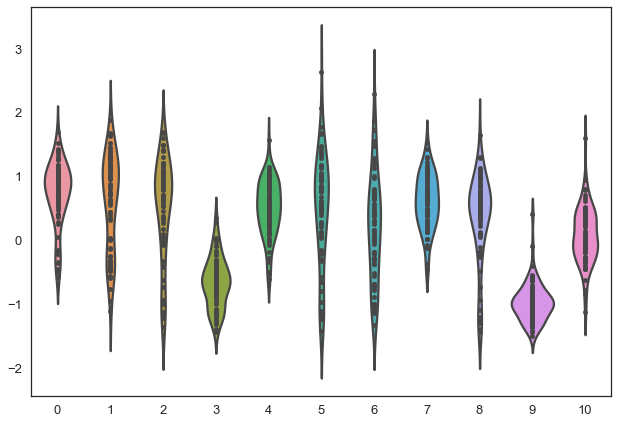

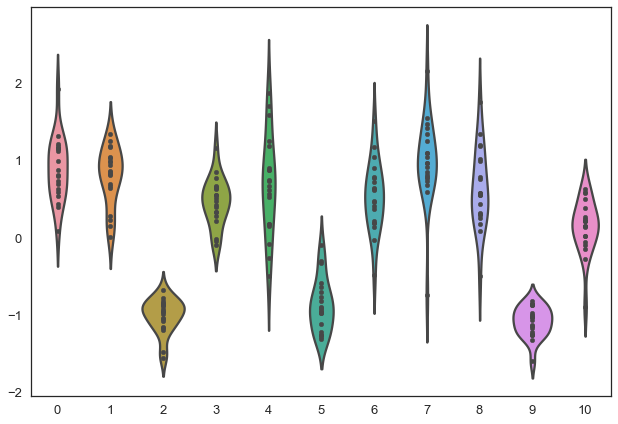

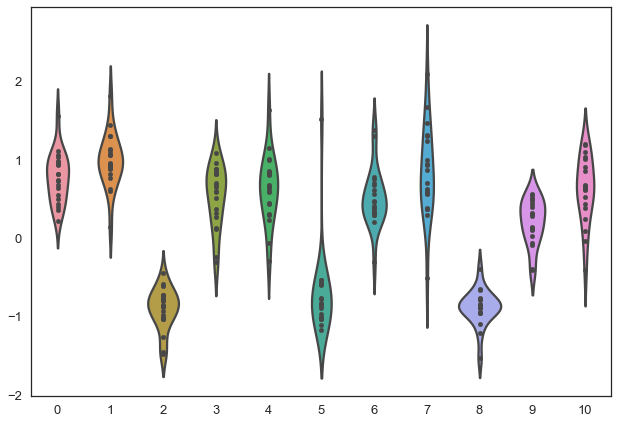

maj BIC:  1307.41147257  N:  15
min BIC:  394.009530128  N:  17
dom BIC:  27.3199038797  N:  14
hdim7 BIC:  -439.340312468  N:  5
dim BIC:  -218.627825004  N:  5


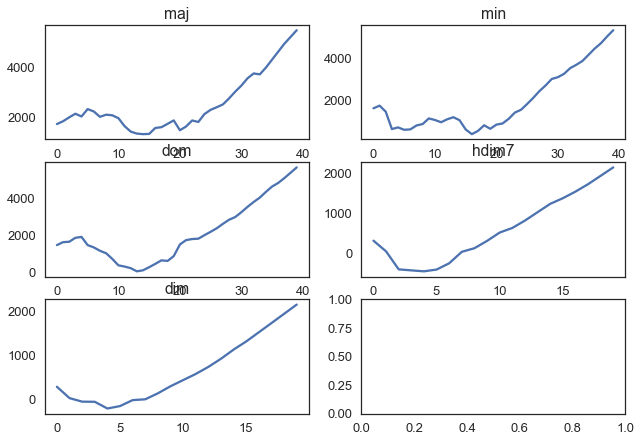

[ 15.  17.  14.   5.   5.]
[  97.1443499    99.48089267  100.          100.          100.        ]
[ 85.8015729   82.34724743  75.41439806  72.63762855  68.80822747]


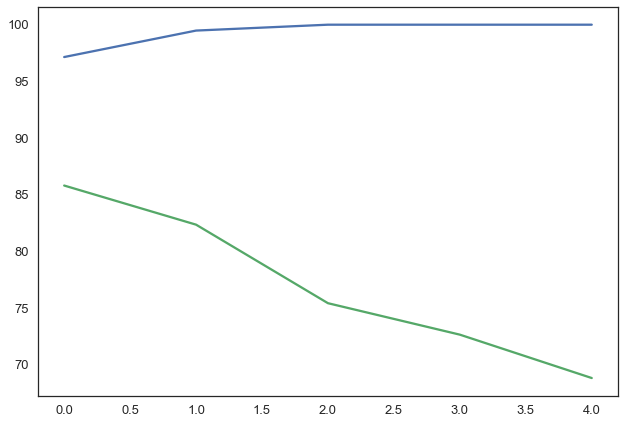

In [52]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../guitar.npz'))

sxChromas = normalizeTo11d(chromas)
violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
score(model, kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,3,3,1,1])
score(model, kinds, sxChromas)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components

trains, tests = trainTestSymmetricalModels(kinds, sxChromas)
print trains
print tests
plt.plot(trains)
plt.plot(tests)
plt.show()